<a href="https://colab.research.google.com/github/yicjiang/Neural_Networks/blob/main/Victor_Jiang's_Blue_Bike_Trip_Duration_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**HOMEWORK: BLUE BIKE TRIP DURATION PREDICTION (Total: / 15 points)**

Context: You have received some data from Blue Bikes (the Boston Bikesharing Service). They have asked you to provide a predictive model that can accurately predict how long a given bike rental will last, at the time the rental begins. The use case is that the bike share company wants to be able to predict how long a customer will have the bike in their possession, when they begin their retnal, in order to better manage operational efficiency across the bike network. Note that when the customer initiates a bike rental, they enter the starting station ID and ending station ID for their trip, into the mobile app.

# *Name: Yicheng(Victor) Jiang*
# *Email: yicjiang@bu.edu*

#*Import and Pre-process Data*

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from keras.optimizers import RMSprop


bluebikes = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2023/main/Lecture%20Materials/C_Assignment/bluebikes_sample.csv')

bluebikes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             9000 non-null   int64  
 1   starttime                9000 non-null   object 
 2   stoptime                 9000 non-null   object 
 3   start station id         9000 non-null   int64  
 4   start station name       9000 non-null   object 
 5   start station latitude   9000 non-null   float64
 6   start station longitude  9000 non-null   float64
 7   end station id           9000 non-null   int64  
 8   end station name         9000 non-null   object 
 9   end station latitude     9000 non-null   float64
 10  end station longitude    9000 non-null   float64
 11  bikeid                   9000 non-null   int64  
 12  usertype                 9000 non-null   object 
 13  birth year               9000 non-null   int64  
 14  gender                  

In [ ]:
bluebikes.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1584,09:36.7,36:00.9,442,Hyde Park Ave at Walk Hill St,42.296067,-71.116012,122,Burlington Ave at Brookline Ave,42.345733,-71.100694,4587,Subscriber,1967,1
1,894,40:48.2,55:43.0,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,144,Rogers St & Land Blvd,42.365758,-71.076994,2340,Subscriber,1994,1
2,973,58:05.4,14:18.4,57,Columbus Ave at Massachusetts Ave,42.340543,-71.081388,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,2910,Subscriber,1994,1
3,606,46:45.0,56:51.4,149,175 N Harvard St,42.363796,-71.129164,221,Verizon Innovation Hub 10 Ware Street,42.372509,-71.113054,4526,Subscriber,1992,1
4,428,49:27.9,56:36.7,426,Surface Rd at Summer St,42.352946,-71.056564,420,Charles St at Pinckney St,42.358725,-71.070795,3780,Subscriber,1989,1


In [ ]:
bluebikes['tripduration'].describe()

count     9000.000000
mean       849.892444
std       1398.751895
min         61.000000
25%        380.000000
50%        623.500000
75%       1023.000000
max      86912.000000
Name: tripduration, dtype: float64

##Data Processing Function

In [ ]:
def processData(data):
    # OneHotEncode categorical variables to generate new columns base on the unique value each categorical variables have
    enc = OneHotEncoder(sparse=False)
    cat_vars = ['usertype', 'gender']
    cat_data = enc.fit_transform(data[cat_vars])

    # Convert one-hot encoded array to a DataFrame with it's value
    cat_columns = enc.get_feature_names_out(cat_vars)
    one_hot_df = pd.DataFrame(cat_data, columns=cat_columns)

 

    ##------------------------------------------------------------------------------------------------------------------------------------------
   
    ## following block convert the start station and end stations' latitudes and longtitudes, and calculate the Haversine distance
    # Convert coordinates from degrees to radians
    data[['start_lat', 'start_lon', 'end_lat', 'end_lon']] = data[['start station latitude', 'start station longitude', 
                                                                   'end station latitude', 'end station longitude']].apply(lambda x: x * math.pi / 180)

    # Calculate the differences in latitude and longitude
    data['dlat'] = data['end_lat'] - data['start_lat']
    data['dlon'] = data['end_lon'] - data['start_lon']

    # Calculate the Haversine distance
    a = (data['dlat']/2).apply(math.sin) ** 2 + data['start_lat'].apply(math.cos) * data['end_lat'].apply(math.cos) * (data['dlon']/2).apply(math.sin) ** 2
    c = 2 * a.apply(math.sqrt).apply(math.asin)

    # Earth radius in kilometers (6,371 km)
    earth_radius = 6371

    # Calculate the distance and add it as a new column
    data['distance'] = earth_radius * c


    ##------------------------------------------------------------------------------------------------------------------------------------------
    # Feature extraction for the start time and stop time
    # Convert starttime and stoptime to M:S.f format and do the extraction
    data['starttime'] = pd.to_datetime(data['starttime'].astype(str), format='%M:%S.%f')
    data['stoptime'] = pd.to_datetime(data['stoptime'].astype(str), format='%M:%S.%f')
    

    # Feature extraction for the start time and stop time in (minute, second, microsend)
    data['start_min'] = data['starttime'].dt.minute
    data['start_sec'] = data['starttime'].dt.second
    data['start_f'] = data['starttime'].dt.microsecond

    data['stop_min'] = data['stoptime'].dt.minute
    data['stop_sec'] = data['stoptime'].dt.second
    data['stop_f'] = data['stoptime'].dt.microsecond



    ##-------------------------------------------------------------------------------------------------------------------------------------------

    # Standardize numerical variables
      ## no need to concat due to change in dataframe directly
    scaler = StandardScaler()
    scaler = StandardScaler()
    ## including start_lat start lon end... calculated distance, start time, stop time...
    numic_var = ['start_lat', 'start_lon', 'end_lat', 'end_lon', 'birth year', 'distance', 
                 'start station latitude', 'start station longitude', 'end station latitude', 'end station longitude',
                 'start_min', 'start_sec', 'start_f', 'stop_min', 'stop_sec', 'stop_f']
    numic_data = scaler.fit_transform(data[numic_var])
    data[numic_var] = numic_data

    ##-----------------------------------------------------------------------------------------------------------------------------------------------------------------------
   
    # Concatenate the one-hot encoded DataFrame with the orginal data DataFrame
    ## Trace back to the df one_hot_df - 1
    data_encoded = pd.concat([data, one_hot_df], axis=1)

    # Then drop with original columns - before the one-hot encoding
    data_encoded = data_encoded.drop(cat_vars + [
                                                 'start station latitude',      ## dropped, already transfer to the start_lat
                                                 'start station longitude',     ## dropped, already transfer to the start_lon
                                                 'end station latitude',        ## dropped, already 'end_lat'
                                                 'end station longitude',       ## already transfer to 'end_lon',
                                                 'starttime',                   ##dropped cause already transfer to to the min, sec, f format
                                                 'stoptime',                    ##dropped cause already transfer to to the min, sec, f format
                                                 'start station name',          ## unmeaningful variable
                                                 'end station name',            ## unmeaningful variable
                                                 'bikeid',                      ## dropped - unrelevant variable for the prediction
                                                 'dlat', 'dlon',                ## dropped - used for calculated the distance betweent start and end station, not meaningful
                                                 'start station id',            ## unmeaningful variable
                                                 'end station id',              ## unmeaningful variable
                                                 'stop_min', 'stop_sec', 'stop_f',        ## dropped cause adding start time and stop time at same time will cause the data leakage
                                                 ##'birth year',                          ## not dropped because user age may affect the durantion of traveling
                                                 ##'start_min', 'start_sec', 'start_f',   ## keep either start_time or stop time
                                                 ##'start_lat', 'start_lon',              ## not dropped
                                                 ##'end_lat', 'end_lon',                  ## not dropped
                                                 ##'distance'                             ## not dropped, distance has effect on travel duration
                                                 ], axis=1)


    ##--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Get predictors and labels
    train_labels = data_encoded['tripduration'].values
    predictors_columns = [col for col in data_encoded.columns if col != 'tripduration' ]
    ##and col != 'stop_min' and col != 'stop_sec' and col != 'stop_f'
    train_predictors = data_encoded[predictors_columns].values

    return train_predictors, train_labels

#*Specify Your Neural Network Architecture, Process Your Sample*

Calling the data pre-processing function on the sample.

In [ ]:
# used the try catch to prevent user ran the data function to process df input multiple time, prevent the error and runtime failures
if os.path.isfile('processed_data.npz'):
    print("Data has already been processed.")
    # Load the processed data
    data = np.load('processed_data.npz')
    predictors, labels = data['predictors'], data['labels']

else:
    try:
        # Process the data
        predictors, labels = processData(bluebikes)

        # Save the processed data
        np.savez('processed_data.npz', predictors=predictors, labels=labels)

        print("Data has been processed and saved.")

    except:
        print("Error processing data. Data may have already been processed.")

print(predictors.shape)
# number of feature here assigning to the variable called input feature, which will pass into the model's input layer
input_features = predictors.shape[1]

print(input_features)
print(labels.shape)


Data has already been processed.
(9000, 14)
14
(9000,)


In [ ]:
def build_model():
    # Create the neural network model
    model = keras.Sequential([
        # Input layer
        layers.Dense(10, activation="relu", input_shape=(input_features,)),
        ##layers.Dropout(0.2),
        layers.BatchNormalization(),

        # Hidden layers
        layers.Dense(10, activation="relu"),
        ##layers.Dropout(0.2),
        layers.BatchNormalization(),

        layers.Dense(10, activation="relu"),
        ##layers.Dropout(0.2),
        layers.BatchNormalization(),

        # Output layer
        layers.Dense(1)
    ])

    # Compile the model with learning rate 0.001
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

    return model

#*Train Your Neural Network Here*

***Note: the following code generate large loss value by loss='mse', talked with professor on Apr 11st about it - average MSE chart.

2 charts plot in this section

In [ ]:
# do a 5 fold cross validation, enrish the test and validation test set size
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize arrays to store the training and validation loss for each epoch for all the folds, (num_folds, 50-represents the number of epochs)
# *****REASON FOR CHOISE EPOCHS 50: Because I tried when epochs = 60, the Average val_loss and average val_mae reach the minimum point around epoach 50*****
train_losses = np.zeros((num_folds, 50))
val_losses = np.zeros((num_folds, 50))
train_maes = np.zeros((num_folds, 50))
val_maes = np.zeros((num_folds, 50))

# k-folds for loop iteration
for fold, (train_index, test_index) in enumerate(kf.split(predictors, labels)):
    # Get the training and testing data for fold base on given predictors and labels in the data() function
    X_train, X_test = predictors[train_index], predictors[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Build and compile the model
    model = build_model()

    # Fit the model on the training data for this fold given epochs 50 and batch size 35
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=35,
                        validation_data=(X_test, y_test))
                        
    # Store the training and validation loss for each epoch for this fold for plt in next few steps
    train_losses[fold] = history.history['loss']
    val_losses[fold] = history.history['val_loss']

    train_maes[fold] = history.history['mae']
    val_maes[fold] = history.history['val_mae']


Epoch 1/50
206/206 [==============================] - 4s 6ms/step - loss: 2961065.2500 - mae: 854.9878 - val_loss: 1542694.6250 - val_mae: 826.9280
Epoch 2/50
206/206 [==============================] - 1s 5ms/step - loss: 2957513.0000 - mae: 853.6748 - val_loss: 1537714.8750 - val_mae: 825.1959
Epoch 3/50
206/206 [==============================] - 1s 5ms/step - loss: 2952082.0000 - mae: 851.7471 - val_loss: 1530187.2500 - val_mae: 822.3490
Epoch 4/50
206/206 [==============================] - 1s 5ms/step - loss: 2945446.5000 - mae: 849.2651 - val_loss: 1521468.6250 - val_mae: 819.1351
Epoch 5/50
206/206 [==============================] - 1s 5ms/step - loss: 2935972.7500 - mae: 846.0832 - val_loss: 1511567.7500 - val_mae: 815.5721
Epoch 6/50
206/206 [==============================] - 1s 5ms/step - loss: 2924881.2500 - mae: 842.3489 - val_loss: 1499283.5000 - val_mae: 810.7645
Epoch 7/50
206/206 [==============================] - 1s 5ms/step - loss: 2913988.7500 - mae: 838.1553 - val_los

Plot your model performance over training here:

<ipython-input-19-79518cfe47fb>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(1, len(avg_train_losses)+1), avg_train_losses, 'b-', label='Avg Training loss', color='blue')
<ipython-input-19-79518cfe47fb>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(range(1, len(avg_val_losses)+1), avg_val_losses, 'g-', label='Avg Validation loss', color='orange')


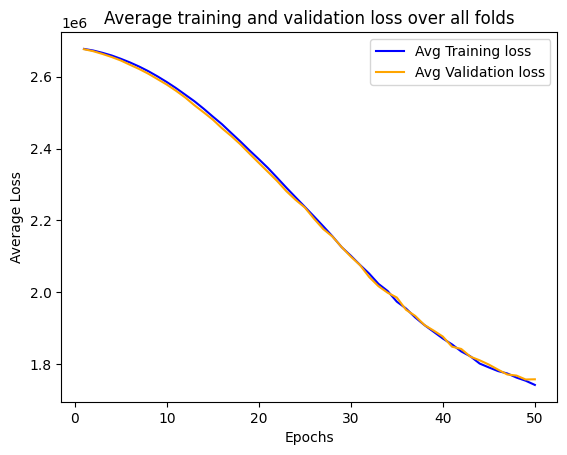

In [ ]:
# Calculate the average training and validation loss for each epoch over all the folds
avg_train_losses = np.mean(train_losses, axis=0)
avg_val_losses = np.mean(val_losses, axis=0)

# Plot the average training loss and average validation loss for each epoch, and show the overall trends
plt.plot(range(1, len(avg_train_losses)+1), avg_train_losses, 'b-', label='Avg Training loss', color='blue')
plt.plot(range(1, len(avg_val_losses)+1), avg_val_losses, 'g-', label='Avg Validation loss', color='orange')
plt.title('Average training and validation loss over all folds')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.legend()
plt.show()


<ipython-input-20-29d16c51fa65>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(1, len(avg_train_maes)+1), avg_train_maes, 'b-', label='Avg Training MAE', color='blue')
<ipython-input-20-29d16c51fa65>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-" (-> color='g'). The keyword argument will take precedence.
  plt.plot(range(1, len(avg_val_maes)+1), avg_val_maes, 'g-', label='Avg Validation MAE', color='green')


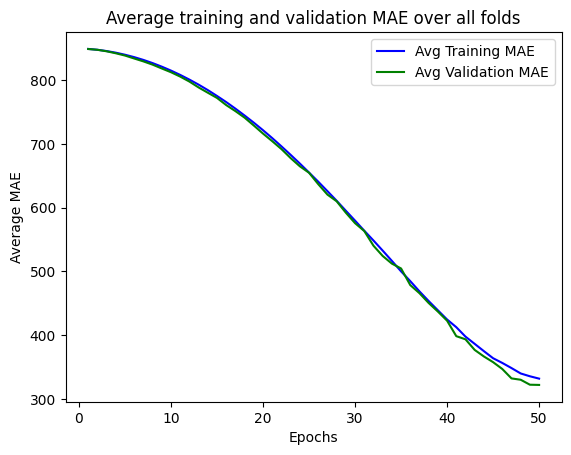

In [ ]:
# calcalate the avg to plot
avg_train_maes = np.mean(train_maes, axis=0)
avg_val_maes = np.mean(val_maes, axis=0)

# Plot the average training MAE and validation MAE for each epoch
plt.plot(range(1, len(avg_train_maes)+1), avg_train_maes, 'b-', label='Avg Training MAE', color='blue')
plt.plot(range(1, len(avg_val_maes)+1), avg_val_maes, 'g-', label='Avg Validation MAE', color='green')
plt.title('Average training and validation MAE over all folds')
plt.xlabel('Epochs')
plt.ylabel('Average MAE')
plt.legend()
plt.show()

Following chart shows above network diagram to answer the Conceptal question 1

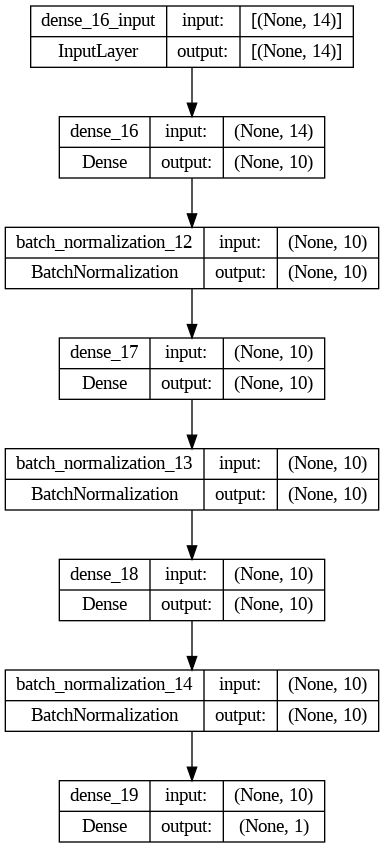

In [ ]:
# graph the model structure
keras.utils.plot_model(model,show_shapes=True)

#*Choose Final Configuration and Produce That Model Here:*

In [ ]:
model = build_model()
model.fit(predictors,labels,epochs=50, batch_size=35)

Epoch 1/50
258/258 [==============================] - 3s 4ms/step - loss: 2676686.5000 - mae: 849.2968
Epoch 2/50
258/258 [==============================] - 1s 4ms/step - loss: 2670128.2500 - mae: 847.3751
Epoch 3/50
258/258 [==============================] - 1s 4ms/step - loss: 2660466.2500 - mae: 844.2497
Epoch 4/50
258/258 [==============================] - 1s 4ms/step - loss: 2648793.2500 - mae: 840.0828
Epoch 5/50
258/258 [==============================] - 1s 4ms/step - loss: 2633354.7500 - mae: 834.5657
Epoch 6/50
258/258 [==============================] - 1s 4ms/step - loss: 2615429.2500 - mae: 827.8580
Epoch 7/50
258/258 [==============================] - 1s 4ms/step - loss: 2594650.0000 - mae: 820.0793
Epoch 8/50
258/258 [==============================] - 1s 4ms/step - loss: 2572730.5000 - mae: 811.2346
Epoch 9/50
258/258 [==============================] - 1s 4ms/step - loss: 2547786.7500 - mae: 801.0112
Epoch 10/50
258/258 [==============================] - 1s 4ms/step - loss

Here's what the resulting model looks like.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                150       
                                                                 
 batch_normalization_15 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 10)                110       
                                                                 
 batch_normalization_16 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 dense_22 (Dense)            (None, 10)                110       
                                                                 
 batch_normalization_17 (Bat  (None, 10)              

#*Final Evaluation*

Don't modify this section; this is the code I will use to evaluate that your model is output properly and that it can generate predictions on new test observations it has never seen before. If your model breaks when I feed it the new data, I will deduct marks, so please ensure that your data pre-processing function works properly!

In [ ]:
from google.colab import files
import io

# I'm going to upload my holdout dataset (same set of features)
uploaded = files.upload()
bluebike_holdout = pd.read_csv(io.BytesIO(uploaded['bluebikes_holdout.csv']))

# I'm then going to pre-process it using your commands.
holdout_predictors, holdout_labels = processData(bluebike_holdout)

# Then I'm going to evaluate your model's performance on that data.
loss_metrics = model.evaluate(holdout_predictors,holdout_labels,verbose=1)